In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus']=False  

import tensorflow as tf
from tensorflow import keras     
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import metrics

# CNN(Convolutional Neural Network)
: 레이아웃 어떻게 쌓을까?
* 합성곱 계층 : 필터 >> 패딩과 스트라이드 >> 폴링 >> 완전 연결층 (Fully Connected Layer) 또는 Affine 계층

## 데이터 분할 및 전처리

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

- 패션 MINST 데이터 셋
    - 데이터셋 : https://www.tensorflow.org/tutorials/keras/classification?hl=ko
    - 데이터 셋 구성 : 크기(N), 높이, 너비

In [15]:
(X_train, Y_train), (X_test, Y_test)=keras.datasets.fashion_mnist.load_data()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape    

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

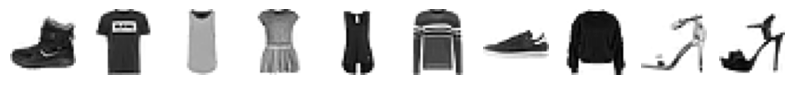

In [17]:
fig, ax=plt.subplots(1, 10, figsize=(10, 10))

for i in range(10):
    ax[i].imshow(X_train[i], cmap='gray_r')
    ax[i].axis('off')
plt.show()

In [19]:
for i in range(10):
    print(Y_train[i], end=' ')

9 0 0 3 0 2 7 2 5 5 

In [23]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

In [25]:
# X_train_scaled=X_train / 255.0
# X_train_scaled.shape                                 #  (60000, 28, 28)

# X_train_scaled=X_train_scaled.reshape(-1, 28 * 28)   # 1 차원 입력
# print(X_train_scaled.shape)

In [30]:
# CNN 3차원 >> 4차원 변환
X_train_scaled=X_train.reshape(-1, 28, 28, 1)  / 255.0   # (샘플수, 높이, 너비, 채널수(1 흑, 3컬러)
print(X_train_scaled.shape, np.max(X_train_scaled), np.min(X_train_scaled))

X_test_scaled=X_test.reshape(-1, 28, 28, 1)  / 255.0
print(X_test_scaled.shape, np.max(X_test_scaled), np.min(X_test_scaled))

(60000, 28, 28, 1) 1.0 0.0
(10000, 28, 28, 1) 1.0 0.0


## 모델 구성 및 학습
- Conv1D (1차원 합성곱) : 시계열 데이터, 자연어 처리 / (시퀀스 길이, 특성 수) / (100, 1)
- Conv2D (2차원 합성곱) : 이미지 처리 / (높이, 너비, 채널) / (28, 28, 1) 흑백 1, 컬러 3
- Conv3D (3차원 합성곱) : 비디오 / (깊이, 높이, 너비, 채널) / (10, 64, 64, 1)

In [37]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(28, 28, 1)))

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same',  activation='relu'))  # 28, 28, 32
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))    # 14, 14, 32

model.add(keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))   # 14, 14, 64
model.add(keras.layers.MaxPooling2D(pool_size=2))        # 7, 7, 64 

model.add(keras.layers.Flatten())  # 7, 7, 64 = 3136
model.add(keras.layers.Dense(100, activation='relu'))  # 3136×100+100=313700 파리미터 수 / 출력 100

model.add(keras.layers.Dropout(0.4))   # 40% 뉴런을 꺼서 일반화 성능 향상 

model.add(keras.layers.Dense(10, activation='softmax'))    # 100×10+10=1010
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

### CallBack 함수

In [44]:
# epoch마다 진행 상황 출력
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 5 == 0:
        if 'mse' in logs:
            print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, mse={logs['mse']:.4f}", 
                  f"val_loss={logs['val_loss']:.4f}, val_mse={logs['val_loss']:.4f}")
        elif 'accuracy' in logs:   
             print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}", 
                  f"val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}")
            
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=2, verbose=1,  restore_best_weights=True)

# 저장 : 모델의 성능이 향상될 때만 저장
check_pointer=keras.callbacks.ModelCheckpoint(filepath='./Deep_result/cnn.keras', monitor='val_loss', 
                                             verbose=1, save_best_only=True)

In [46]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### 학습 및 평가

In [49]:
history=model.fit(X_train_scaled, Y_train,
                  epochs=5, batch_size=32, validation_split=0.2, 
                  callbacks=[print_callback, check_pointer, early_stopping_callback])

Epoch 1/5
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7379 - loss: 0.7171
Epoch 1: val_loss improved from inf to 0.33507, saving model to ./Deep_result/cnn.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.7380 - loss: 0.7167 - val_accuracy: 0.8774 - val_loss: 0.3351
Epoch 2/5
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8687 - loss: 0.3674
Epoch 2: val_loss improved from 0.33507 to 0.28067, saving model to ./Deep_result/cnn.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8687 - loss: 0.3673 - val_accuracy: 0.8955 - val_loss: 0.2807
Epoch 3/5
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8891 - loss: 0.3119
Epoch 3: val_loss improved from 0.28067 to 0.25816, saving model to ./Deep_result/cnn.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.8891 - loss: 0.3119 - val_accuracy: 0.9047 - val_loss: 0.2582
Epoch 4/5
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9018 - loss: 0.2698
Epoch 4: val_

In [71]:
model.evaluate(X_test_scaled, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9085 - loss: 0.2638


[0.25770804286003113, 0.9075000286102295]

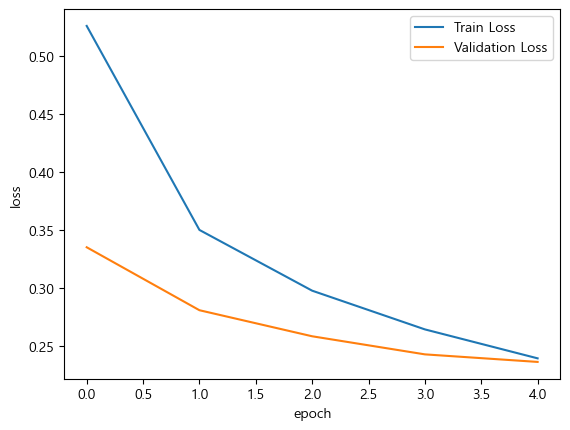

In [53]:
# 그래프 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [75]:
pred_prob=model.predict(X_test_scaled)         # 각 행의 값
pred=np.argmax(pred_prob, axis=1)              # 가장 큰 값을 가진 인덱스
pred[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


9

In [77]:
print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.88      0.85      1000
           3       0.92      0.90      0.91      1000
           4       0.86      0.84      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.75      0.73      1000
           7       0.94      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



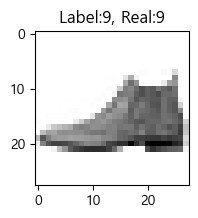

In [79]:
plt.figure(figsize=(2, 2))
plt.imshow(X_test_scaled[0].reshape(28, 28), cmap='gray_r')  # 그림
plt.title(f'Label:{pred[0]}, Real:{Y_test[0]}')             # 예측 값
plt.show()

In [81]:
# 가중치 저장 
model.save_weights('./Deep_result/cnn.weights.h5')

In [83]:
# 불러오기
model_fminst_load=load_model('./Deep_result/cnn.keras')
model_fminst_load.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,580 (3.82 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 667,054 (2.54 MB)

In [88]:
model_fminst_load.load_weights('./Deep_result/cnn.weights.h5')
model_fminst_load.evaluate(X_test_scaled, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9085 - loss: 0.2638


[0.25770804286003113, 0.9075000286102295]

In [60]:
# End of file